# Analysis Recommendation components

In [1]:
import sys
import os
import matplotlib.pyplot as plt

from simulation_classes import *
from data_classes import *
from simulation import *

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

print(current_dir)
print(parent_dir)
sys.path.append(parent_dir)

from util import Config, get_next_day

""" Configuration """
c = Config()
config, current_path = c.config, c.path
tickers_in_scope = config["Tickers"]
simulation_db_alias = "simulation_db"
data_db_alias = "data_db"

# MongoDB Configuration
connect(
    db=config["MONGO_DB"]["DbName"],
    host=config["MONGO_DB"]["ClientUri"],
    alias=data_db_alias
)
connect(
    db=config["MONGO_DB"]["SimulationDbName"],
    host=config["MONGO_DB"]["ClientUri"],
    alias=simulation_db_alias
)

c:\Users\micha\Documents\MSE\Master Thesis\repo\masterthesis\agent_chat
c:\Users\micha\Documents\MSE\Master Thesis\repo\masterthesis


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary(), uuidrepresentation=3)

## Recommendation components

                     Date  Ticker  Trader  Score  Explanation
Component                                                    
Economic indicators  7545    7545    7545   7545         7545
Financials           7545    7545    7545   7545         7545
General news         7545    7545    7545   7545         7545
Miscellaneous        7545    7545    7545   7545         7545
Prices and volumes   7545    7545    7545   7545         7545
Stock news           7545    7545    7545   7545         7545
Technical analysis   7545    7545    7545   7545         7545


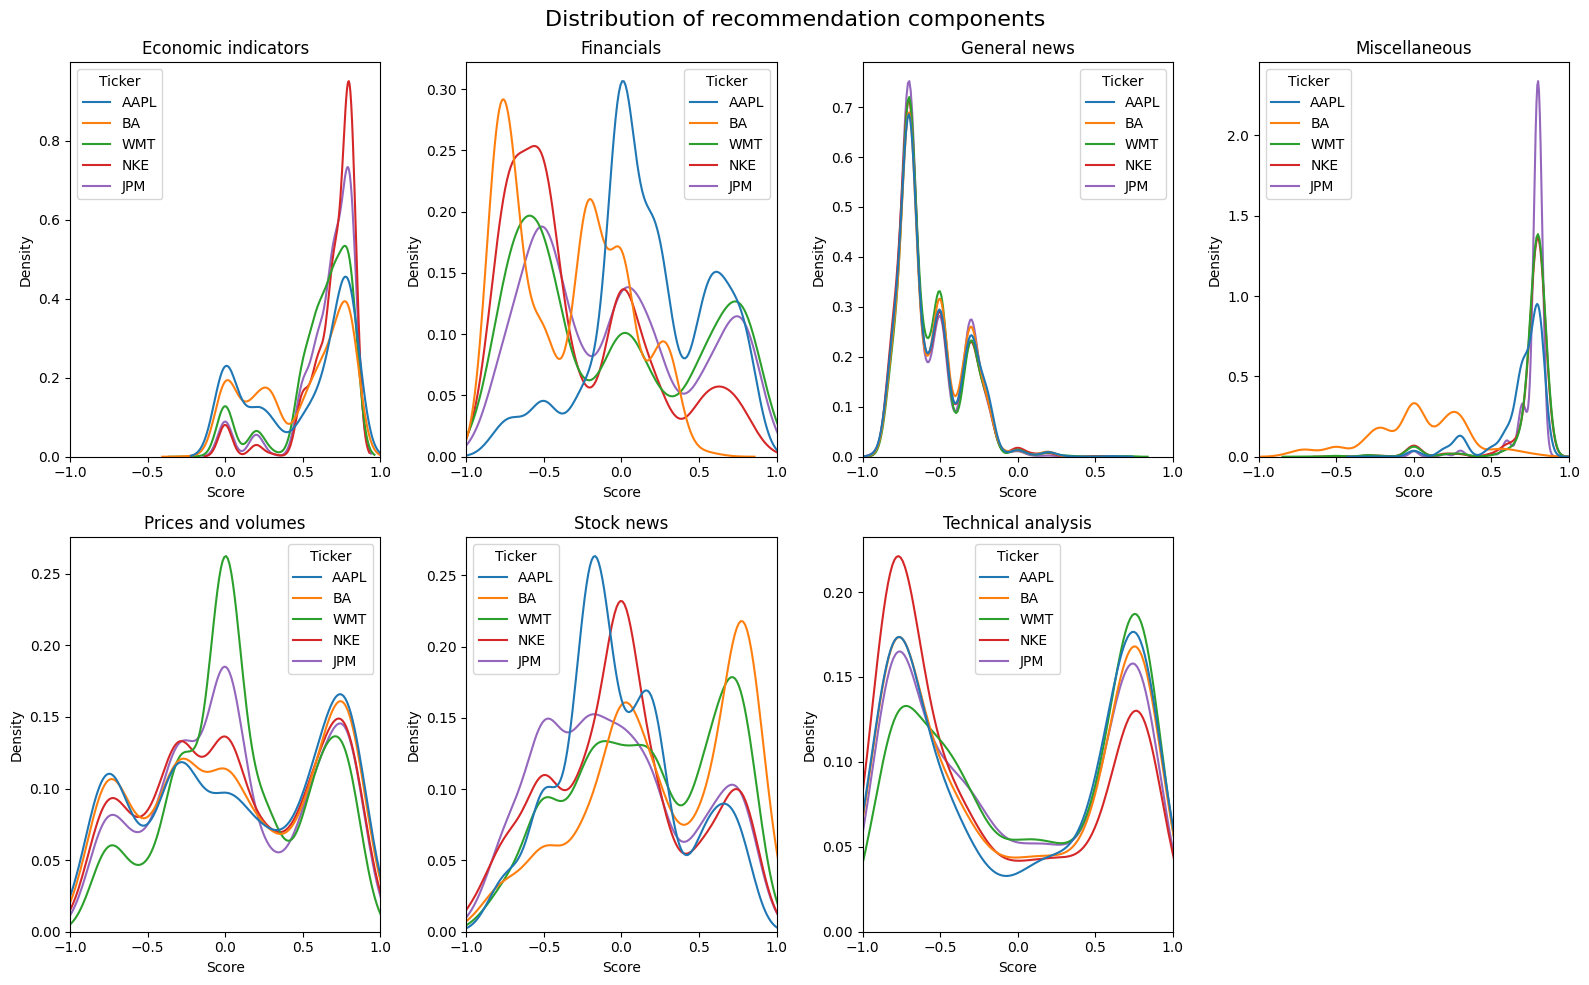

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

simulation_id = "97e4fa3e-a106-40fc-9d11-4d01e61e5d16"

rc_documents = RecommendationComponent.objects(simulation_id=simulation_id, score__ne=None)
df = pd.DataFrame.from_records(rc_documents.values_list("date", "name", "ticker", "agent_name", "score", "explanation"), columns=["Date", "Component", "Ticker", "Trader", "Score", "Explanation"])
df.loc[df["Component"] == "Last prices", "Component"] = "Prices and volumes"

#print(df.head())
print(df.groupby("Component").count())

component_list = df["Component"].unique()

fig, axes = plt.subplots(2, 4, figsize=(16, 10))  # Create a 2x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, component in enumerate(component_list):
    df_component = df[df["Component"] == component]
    title = f"{component}"
    tickers = df_component["Ticker"].unique()
    sns.kdeplot(data=df_component, x="Score", hue="Ticker", multiple="layer", ax=axes[i], hue_order=tickers)
    axes[i].set_title(title)
    axes[i].set_xlim(-1, 1)  # Set x-axis limits
    axes[i].set_xlabel("Score")  # Set x-axis label
    axes[i].set_ylabel("Density")  # Set y-axis label

# Hide empty subplots if the number of components is less than 8
for ax in axes[len(component_list):]:
    ax.remove()

plt.suptitle("Distribution of recommendation components", fontsize=16)  # Set title for the entire plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Show the plot


In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime

FROM_DATE = datetime(2022, 1, 1)
TO_DATE = datetime(2023, 12, 31)
simulation_id = "97e4fa3e-a106-40fc-9d11-4d01e61e5d16"

tickers = Simulation.objects(simulation_id=simulation_id).first().tickers_list
rc_documents = RecommendationComponent.objects(simulation_id=simulation_id, score__ne=None, date__gte=FROM_DATE, date__lt=TO_DATE)
df = pd.DataFrame.from_records(rc_documents.values_list("date", "name", "ticker", "agent_name", "score", "explanation"), columns=["Date", "Component", "Ticker", "Trader", "Score", "Explanation"])
components = df["Component"].unique()

for ticker in tickers:
    prices_documents = PolygonAggregates.objects(ticker=ticker, timestamp__gte=FROM_DATE, timestamp__lte=TO_DATE)
    prices_extracted = pd.DataFrame.from_records(prices_documents.values_list("high", "low", "close", "open", "volume", "timestamp"), columns=["High", "Low", "Close", "Open", "Volume", "Timestamp"])

    ticker_components_df = df[df["Ticker"] == ticker]
    grouped_ticker_components_df = ticker_components_df.groupby(["Date", "Component"])["Score"].mean().reset_index()
    
    # Define row heights for subplots (adjust as needed)
    row_heights = [0.6] + [0.4 / len(components)] * len(components)

    # Candlestick chart
    fig = make_subplots(rows=len(components)+1, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights=row_heights, subplot_titles=[f"Candlestick chart for {ticker}"] + components.tolist())
    
    # Add candlestick chart to the upper subplot
    fig.add_trace(go.Candlestick(
        x=prices_extracted["Timestamp"],
        open=prices_extracted["Open"],
        high=prices_extracted["High"],
        low=prices_extracted["Low"],
        close=prices_extracted["Close"],
        name="Candlestick"
    ), row=1, col=1)

            
    # Set y-axis range for components
    fig.update_yaxes(
            title_text="Price [USD]", 
            row=1, 
            col=1,
            title_font=dict(size=18), 
            tickfont=dict(size=12)
    )

    # Add line charts for each component to the lower subplot
    for i, component in enumerate(components, start=2):
        component_data = grouped_ticker_components_df[grouped_ticker_components_df["Component"] == component]
        fig.add_trace(go.Scatter(
            x=component_data["Date"],
            y=component_data["Score"],
            mode='lines',
            name=component,
            line=dict(color="gray"),
        ), row=i, col=1)
        
        # Set y-axis range for components
        fig.update_yaxes(
            title_text="Score", 
            range=[-1, 1], 
            row=i, 
            col=1,
            title_font=dict(size=18), 
            tickfont=dict(size=12)
        )

    fig.update_xaxes(
        title_text="Time",
        tickmode='auto', 
        tick0=FROM_DATE, 
        dtick="M1", 
        tickangle=0, 
        title_font=dict(size=18), 
        tickfont=dict(size=12),
        row=8,
        col=1
    )

    fig.update_annotations(font_size=20) 

    # Update layout
    fig.update_layout(
        title={'text': f"Candlestick Plot with Components for Ticker {ticker}", 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
        title_font=dict(size=30),
        margin=dict(l=80, r=50, t=120, b=20),
        font=dict(size=10),
        xaxis_rangeslider_visible=False,
        showlegend=False,
        height=1200,  # Adjust height as needed
        width=1600,   # Adjust width as needed
        font_color="black"
    )

    fig.show()


## Correlation analysis

In [6]:
import pandas as pd
import swifter
import numpy as np
from datetime import datetime

FROM_DATE = datetime(2022, 1, 1)
TO_DATE = datetime(2023, 12, 31)
# simulation_id = "850de6d4-2f2e-4368-8de4-b147717484c4" # Basis
# simulation_id = "1cd3a77b-b0b3-4694-a9e7-99b39153c455" # Stock news
# simulation_id = "99f73571-b897-4d92-bb11-831e2baaf653" # General news
# simulation_id = "34346080-54ee-48b2-81f9-e1e525cb46d0" # Financials
simulation_id = "97e4fa3e-a106-40fc-9d11-4d01e61e5d16"

def get_current_price_custom(ticker: str, eval_date: pd._libs.tslibs.timestamps.Timestamp) -> float:
    eval_date_python = eval_date.to_pydatetime()
    price = PolygonAggregates.objects(ticker=ticker, timestamp__lte=eval_date_python).order_by("-timestamp").limit(1).first().close
    return price

def get_next_price_custom(ticker: str, eval_date: pd._libs.tslibs.timestamps.Timestamp) -> float:
    eval_date_python = eval_date.to_pydatetime()
    price = PolygonAggregates.objects(ticker=ticker, timestamp__gt=eval_date_python).order_by("timestamp").limit(1).first().close
    return price

tickers = Simulation.objects(simulation_id=simulation_id).first().tickers_list
rc_documents = RecommendationComponent.objects(simulation_id=simulation_id, score__ne=None, date__gte=FROM_DATE, date__lt=TO_DATE)
df_recommendations = pd.DataFrame.from_records(rc_documents.values_list("date", "name", "ticker", "agent_name", "score"), columns=["Date", "Component", "Ticker", "Trader", "Score"])
# Convert strings into strings
df_recommendations["Ticker"] = df_recommendations["Ticker"].astype(str)
df_recommendations["Trader"] = df_recommendations["Trader"].astype(str)
df_recommendations["Component"] = df_recommendations["Component"].astype(str)

# Apply the function using swifter for parallel computation
df_recommendations["Current price"] = df_recommendations.swifter.apply(lambda row: get_current_price_custom(row["Ticker"], row["Date"]), axis=1)
df_recommendations["Next price"] = df_recommendations.swifter.apply(lambda row: get_next_price_custom(row["Ticker"], row["Date"]), axis=1)

# Calculate difference
df_recommendations["Relative change"] = ((df_recommendations["Next price"] - df_recommendations["Current price"]) / df_recommendations["Current price"]) * 100
df_recommendations["Relative change clipped"] = np.clip(df_recommendations["Relative change"], -1, 1)


print(df_recommendations.head(20))

Pandas Apply:   0%|          | 0/52710 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/52710 [00:00<?, ?it/s]

                  Date            Component Ticker   Trader  Score  \
0  2022-01-03 09:00:00  Economic indicators   AAPL  Trader1    0.7   
1  2022-01-03 09:00:00  Economic indicators     BA  Trader1    0.2   
2  2022-01-03 09:00:00  Economic indicators    WMT  Trader1    0.8   
3  2022-01-03 09:00:00  Economic indicators    NKE  Trader1    0.7   
4  2022-01-03 09:00:00  Economic indicators    JPM  Trader1    0.8   
5  2022-01-03 09:00:00  Economic indicators   AAPL  Trader2    0.8   
6  2022-01-03 09:00:00  Economic indicators     BA  Trader2    0.3   
7  2022-01-03 09:00:00  Economic indicators    WMT  Trader2    0.8   
8  2022-01-03 09:00:00  Economic indicators    NKE  Trader2    0.8   
9  2022-01-03 09:00:00  Economic indicators    JPM  Trader2    0.8   
10 2022-01-03 09:00:00  Economic indicators   AAPL  Trader3    0.7   
11 2022-01-03 09:00:00  Economic indicators     BA  Trader3    0.8   
12 2022-01-03 09:00:00  Economic indicators    WMT  Trader3    0.8   
13 2022-01-03 09:00:

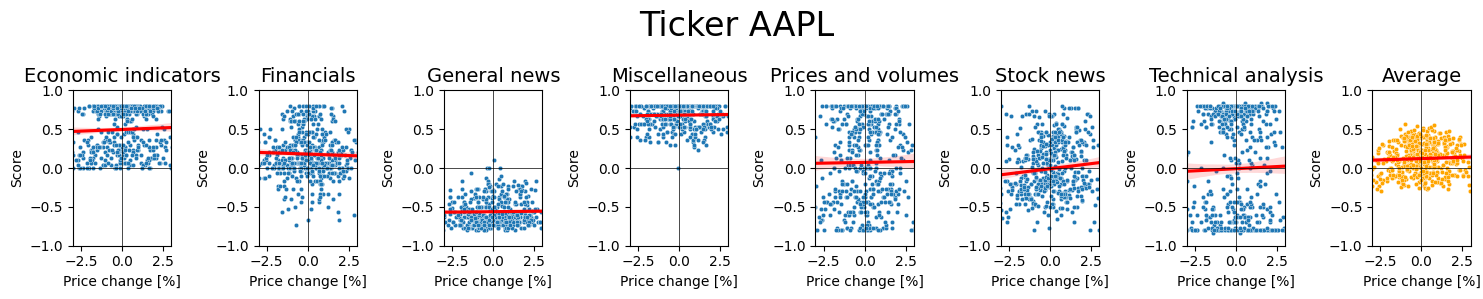

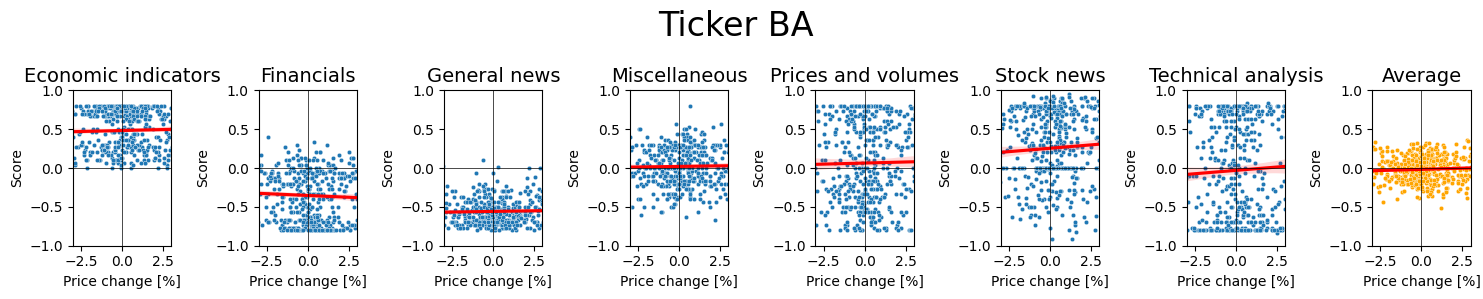

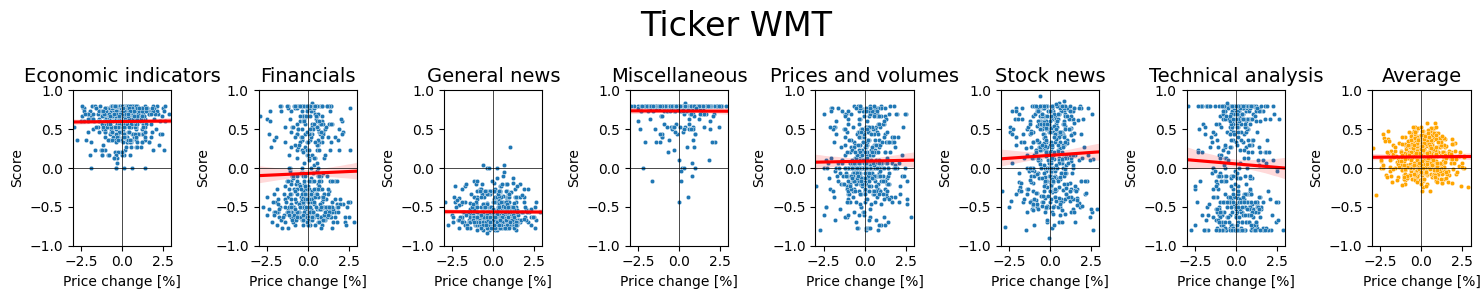

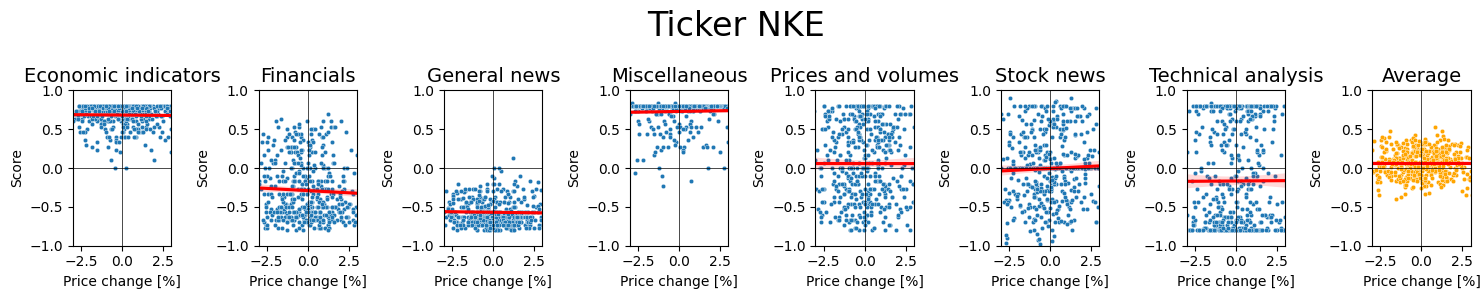

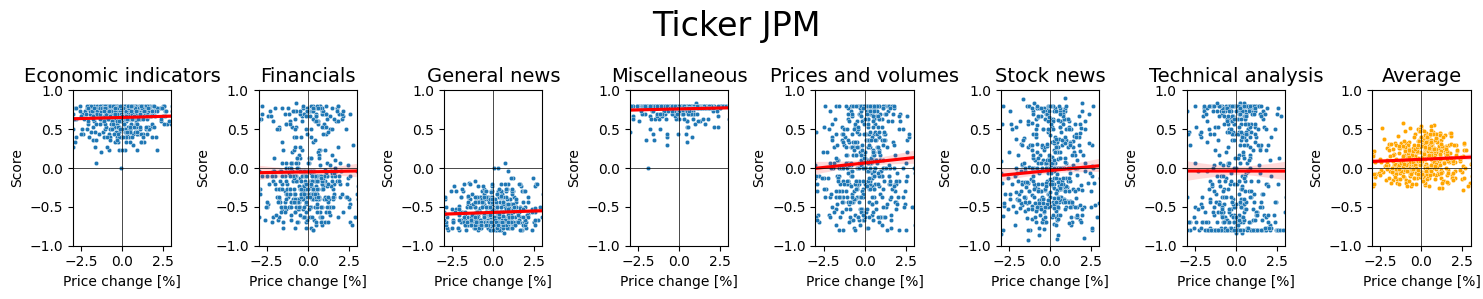

In [8]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

#df_subset = df_recommendations[abs(df_recommendations["Score"]) >= 0.7]

component_list = df_recommendations["Component"].unique()
ticker_list = df_recommendations["Ticker"].unique()
traders_list = df_recommendations["Trader"].unique()

for ticker in ticker_list:
    ticker_df = df_recommendations[df_recommendations["Ticker"] == ticker]
    fig, axes = plt.subplots(1, 8, figsize=(15, 3))  # Create a 2x4 grid of subplots
    axes = axes.flatten()  # Flatten the axes array for easier iteration
    for i, component in enumerate(component_list):
        component_df = ticker_df[ticker_df["Component"] == component]
        # print(component_df.head(10))
        grouped_components_df = component_df.groupby(["Date", "Component", "Relative change", "Next price", "Current price"])["Score"].mean().reset_index()
        title = f"{component}"
        sns.scatterplot(data=grouped_components_df, x="Relative change", y="Score", ax=axes[i], s=10)
        sns.regplot(data=grouped_components_df, x="Relative change", y="Score", ax=axes[i], scatter=False, color='red')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_ylim(-1, 1)  # Set x-axis limits
        axes[i].set_xlim(-3, 3)
        axes[i].set_xlabel("Price change [%]")  # Set x-axis label
        axes[i].set_ylabel("Score")  # Set y-axis label
        axes[i].axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
        axes[i].axvline(0, color='black', linewidth=0.5)  # Vertical line at x=0

    # Average
    ax_idx = 7
    grouped_average_df = ticker_df.groupby(["Date", "Relative change"])["Score"].mean().reset_index()
    sns.scatterplot(data=grouped_average_df, x="Relative change", y="Score", ax=axes[ax_idx], color="orange", s=10)
    sns.regplot(data=grouped_average_df, x="Relative change", y="Score", ax=axes[ax_idx], scatter=False, color='red')
    axes[ax_idx].set_title("Average", fontsize=14)
    axes[ax_idx].set_ylim(-1, 1)  # Set x-axis limits
    axes[ax_idx].set_xlim(-3, 3)
    axes[ax_idx].set_xlabel("Price change [%]")  # Set x-axis label
    axes[ax_idx].set_ylabel("Score")  # Set y-axis label
    axes[ax_idx].axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
    axes[ax_idx].axvline(0, color='black', linewidth=0.5)  # Vertical line at x=0

    plt.suptitle(f"Ticker {ticker}", fontsize=24)  # Set title for the entire plot
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()  # Show the plot
